Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Training a GNN to do Fraud Detection on Graphcore IPUs using your own dataset with PyTorch Geometric

TODO: Everything in this section

TODO: Update links:

[![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)  [![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

>
> We aim to have our notebook app demos to be focused on what the user is trying to
> do. To help you do this correctly please read [our user personnas](https://graphcore.atlassian.net/wiki/spaces/PM/pages/3157131517/Notebook+personas#Ellie%3A-The-Data-Scientist%2C-Business-Analysis%2C-Consultant),
and when in doubt ask yourself "does that person care about this?".
> To support that the first paragraph will contain all the key information, to
> help users rapidly identify if this is the right notebook for them to go
> though, based on:
>
> - The task/business problem they are trying to solve,
> - The features that are used (Focus on big picture Deep learning features - e.g.
>  Distributed training, not I/O overlap).
>
> To achieve this, each notebook should start with the following 3 paragraphs
> (detailed in the next three comments):
>
> - a table highlighting what we are going to do
> - a very short intro (3-5 sentences)
> - clear "steps to resolution" (bullet points stating what the user will have
>    to do to tackle their problem on the IPU - these need to reflect the notebook,
>    and be as simple as possible)
> - links to additional related resources.
>

|  Domain | Tasks | Model | Datasets | Workflow |   Number of IPUs   | Execution time |
|---------|-------|-------|----------|----------|--------------|--------------|
|   GNNs   |  Fraud detection  | ? | ? | Training, evaluation | recommended: 16XX (min: 4X) | 20Xmn (X1h20mn)   |

>
>
> Start with a short introduction to the notebook. [suggested 3-5 sentences]
>
> This intro should focus on the problem you are fixing, and not on any IPU specific
> or framework specific features. The mindset is that anything that is non-standard
> is a barrier to entry, and will risk the user giving up.
>
> This short introduction should be followed by a clear bullet point summary of
> the steps of the demo. Each outcome should be of the form:
> - what the user will do (active verb) [and (optionally) how they do
>   it]. Jargon, if any, goes to the end of the bullet point.

In this demo, you will learn how to:

- Turn tabular transaction data into a PyTorch Geometric dataset
- Select a model suitable for the task of predicting fraudulent transactions
- Train the model on Graphcore IPUs
- Run validation on the trained model

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
* [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html)
* [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch)
* [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)
* [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html)

[![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

In [1]:
# Make imported python modules automatically reload when the files are changed
# needs to be before the first import.
%load_ext autoreload
%autoreload 2
# TODO: remove at the end of notebook development

## Environment setup

[![Run on Gradient](../../gradient-badge.svg)](TODO)

The best way to try this demo is on Paperspace Gradient's cloud IPUs. To use on other hardware
make sure that you have the Poplar SDK enabled with the latest PopTorch Geometric installed.

In [2]:
%pip install -q -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mordred 1.2.0 requires networkx==2.*, but you have networkx 3.1 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


To improve your experience we read some configuration related to the environment you are running the notebook in.

In [3]:
import os

number_of_ipus = int(os.getenv("NUM_AVAILABLE_IPU", 16))
pod_type = os.getenv("GRAPHCORE_POD_TYPE", "pod16")
executable_cache_dir = os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/")

# TODO Remove default
dataset_directory = os.getenv("DATASETS_DIR", "~")
checkpoint_directory = os.getenv("CHECKPOINT_DIR")

## Loading tabular data into PyTorch Geometric

In [4]:
import torch

### Getting the dataset

TODO: Using https://www.kaggle.com/c/ieee-fraud-detection/data

TODO: Run a script to download and tidy data?

In [31]:
import os.path as osp
import pandas as pd

raw_dataset_path = osp.join(dataset_directory, "ieee-fraud-detection", "raw")

train_transaction_path = osp.join(raw_dataset_path, "train_transaction.csv")
train_identity_path = osp.join(raw_dataset_path, "train_identity.csv")
train_transaction_df = pd.read_csv(train_transaction_path)
train_identity_df = pd.read_csv(train_identity_path)

test_transaction_path = osp.join(raw_dataset_path, "test_transaction.csv")
test_identity_path = osp.join(raw_dataset_path, "test_identity.csv")
test_transaction_df = pd.read_csv(test_transaction_path)
test_identity_df = pd.read_csv(test_identity_path)

In [32]:
transaction_df = pd.concat([train_transaction_df, test_transaction_df], axis=0)
identity_df = pd.concat([train_identity_df, test_identity_df], axis=0)

In [33]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# TODO: Remove this
#transaction_df = transaction_df.head(500)
#identity_df = identity_df.head(500)

In [36]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Sort by datetime, later we will use this to make a training and validation split
transaction_df.sort_values("TransactionDT")

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2987495,0.0,94795,250.000,W,8394,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,2987496,0.0,94803,107.950,W,17129,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,2987497,0.0,94829,39.000,W,12686,215.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,2987498,0.0,94851,100.000,W,7377,555.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# TODO: Merge tables
transaction_df = pd.merge(transaction_df, identity_df, on="TransactionID")

In [40]:
transaction_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38
0,2987004,0.0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987008,0.0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987010,0.0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,0.0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2987485,0.0,94622,25.000,H,18092,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,2987488,0.0,94642,15.105,C,15885,545.0,185.0,visa,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,2987489,0.0,94645,8.700,C,3154,408.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,2987490,0.0,94716,100.000,H,6019,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inspecting the dataset

TODO: Look at a few of the columns - call out important ones we will use for features and labels

TODO: Create validation / test split

NOTES: TODO: Remove

- Nodes are transaction IDs
-

### Creating a PyTorch Geometric dataset

TODO: Create PyTorch Geometric dataset from above - maybe move to a separate script

Encoders

! python ./data-preprocessing/graph_data_preprocessor.py --data-dir $dest_dir --output-dir $output_dir --id-cols 'card1,card2,card3,card4,card5,card6,ProductCD,addr1,addr2,P_emaildomain,R_emaildomain' '--cat-cols' 'M1,M2,M3,M4,M5,M6,M7,M8,M9'

! python ./data-preprocessing/graph_data_preprocessor.py --data-dir $dest_dir --output-dir $output_dir --id-cols 'card1,card2,card3,card4,card5,card6,ProductCD,addr1,addr2,P_emaildomain,R_emaildomain' '--cat-cols' 'M1,M2,M3,M4,M5,M6,M7,M8,M9'


Node types:
    card1,card2,card3,card4,card5,card6,ProductCD,addr1,addr2,P_emaildomain,R_emaildomain

Transaction features are all the others:
    Cat features = 'M1,M2,M3,M4,M5,M6,M7,M8,M9'

- Convert all NaN to 0

Transaction
 - from col TransactionAmt - apply(np.log10)? - normalize?
 - M1 - 9 - categorical?

Product Code
 - from col ProductCD - Categorical
 - If NaN drop edge

Purchaser email domain
 - from col P_emaildomain - Categorical
 - If NaN drop edge

Recipient email domain
 - from col R_emaildomain - Categorical
 - If NaN drop edge

Purchaser billing address
 - from col addr1 - Categorical
 - from col addr2 - Categorical
 - If NaN drop edge

Card details
 - from col card1
 - from col card2
 - from col card3
 - from col card4
 - from col card5
 - from col card6
 - If NaN drop edge

In [41]:
node_types = ["card1", "card2", "card3", "card4", "card5", "card6", "ProductCD", "addr1", "addr2", "P_emaildomain", "R_emaildomain"]
# Add Identity columns to node_types
node_types.extend(identity_df.columns)

In [42]:
excl_cols = ["TransactionID", "isFraud", "TransactionDT"]
transaction_cat_features = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"]
transaction_features = [column for column in transaction_df.columns if column not in node_types + excl_cols + transaction_cat_features]

In [67]:
# Process categorical transaction features

# TODO: From pyg
# TODO: I think this can be values instead of 0 and 1

class CategoricalEncoder:

    def __init__(self, key):
        self.key = key

    def __call__(self, df):
        categories = set(row[self.key] for _, row in df.iterrows())
        mapping = {cat: i for i, cat in enumerate(categories)}

        x = torch.zeros(len(df), len(mapping))
        for i, row in df.iterrows():
            x[i, mapping[row[self.key]]] = 1
        return x


cat_encoders = [CategoricalEncoder(key) for key in transaction_cat_features]
cat_features = [cat_enc(transaction_df) for cat_enc in cat_encoders]
node_feats = torch.cat(cat_features, dim=-1)
node_feats[0]


tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.])

In [68]:
# Process non-categorical transaction features

# TODO: Do something with transactions amounts np.log

def process_val(val):
    if pd.isna(val):
        return 0.0
    return val

other_feats = [
    list(map(process_val, [row[feat] for feat in transaction_features]))
    for _, row in transaction_df.iterrows()
]
other_feats = torch.tensor(other_feats)
other_feats.shape

torch.Size([131, 371])

In [69]:
import torch.nn.functional as F

# TODO: node feats is now too big
node_feats = torch.cat((node_feats, other_feats), -1)
node_feats.shape

torch.Size([131, 382])

In [70]:
# TODO: Pad to embedding size
node_feats = F.pad(node_feats, (0, 128 - node_feats.shape[1], 0, 0), "constant", 0.0)
node_feats.shape

torch.Size([131, 128])

In [49]:
# Make labels

y = [row["isFraud"] for _, row in transaction_df.iterrows()]
y = torch.tensor(y, dtype=torch.long)
y.shape

/tmp/ipykernel_39514/2999866338.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(y, dtype=torch.long)


torch.Size([131])

In [50]:
# Make edge list and edge types

from tqdm import tqdm

num_transactions = len(transaction_df)

edge_lists = torch.zeros((2, num_transactions, len(node_types)), dtype=torch.long)
edge_types = torch.zeros((num_transactions, len(node_types)), dtype=torch.long)

# {P_emaildomain: {gmail: 0, hotmail: 1}, ...}
node_type_lookup = {node_type: {} for node_type in node_types}

next_target_node_id = 0
next_non_target_node_id = num_transactions

for t_idx, transaction in tqdm(transaction_df.iterrows()):
    t_node_id = next_target_node_id
    next_target_node_id += 1
    for n_idx, node_type in enumerate(node_types):
        node = transaction[node_type]
        if pd.isna(node):
            continue

        if node in node_type_lookup[node_type]:
            node_id = node_type_lookup[node_type][node]
        else:
            node_id = next_non_target_node_id
            node_type_lookup[node_type][node] = node_id
            next_non_target_node_id += 1

        edge_lists[0][t_idx][n_idx] = t_node_id
        edge_lists[1][t_idx][n_idx] = node_id
        edge_types[t_idx][n_idx] = n_idx

131it [00:45,  2.91it/s]


In [285]:
# Make dataset splits

transaction_ids = torch.arange(0, num_transactions)
num_train = int(0.8 * num_transactions)

train_idx = transaction_ids[:num_train]
train_y = y[:num_train]
test_idx = transaction_ids[num_train:]
test_y = y[num_train:]

In [272]:
{node_type: len(nodes) for node_type, nodes in node_type_lookup.items()}

{'card1': 290,
 'card2': 128,
 'card3': 4,
 'card4': 4,
 'card5': 21,
 'card6': 2,
 'ProductCD': 5,
 'addr1': 114,
 'addr2': 66,
 'P_emaildomain': 27,
 'R_emaildomain': 14}

In [273]:
num_non_target_nodes = sum([len(nodes) for nodes in node_type_lookup.values()])
num_non_target_nodes

675

In [275]:
import torch.nn.functional as F

x = F.pad(node_feats, (0, 0, 0, next_non_target_node_id - next_target_node_id), "constant", 0.0)
edge_index = torch.reshape(edge_lists, (2, len(node_types) * num_transactions))
edge_type = torch.reshape(edge_types, (len(node_types) * num_transactions, ))
edge_index, edge_type

(tensor([[   0,    0,    0,  ...,  499,  499,  499],
         [ 500,  501,  502,  ..., 1174,  516,  557]]),
 tensor([ 0,  1,  2,  ...,  8,  9, 10]))

In [276]:
from torch_geometric.data import Data

data = Data()
data.edge_index = edge_index
data.edge_type = edge_type
data.x = x
data.num_nodes = next_non_target_node_id
data.train_idx = train_idx
data.train_y = train_y
data.test_idx = test_idx
data.test_y = test_y

In [277]:
data

Data(edge_index=[2, 5500], edge_type=[5500], x=[1175, 128], num_nodes=1175, train_idx=[400], train_y=[400], test_idx=[100], test_y=[100])

In [51]:
# TODO: Check number of fraudulent transactions

### Visualize

KeyboardInterrupt: 

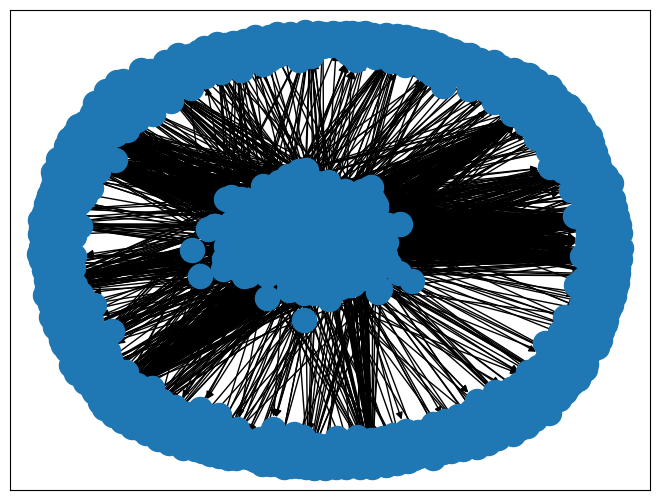

In [192]:
import networkx as nx
from matplotlib import pyplot as plt
from torch_geometric.utils import to_networkx

# Convert to homogeneous
g = to_networkx(data)

# TODO: This maybe?
## Get labels
#labels = {str(idx): val for idx, val in enumerate(data_homogeneous.y)}

# Plot the graph
nx.draw(g)
plt.show()

## Preprocess

In [253]:
import torch_geometric.transforms as T

# TODO: Uncomment
# data = T.ToUndirected()(data)
# data = T.AddSelfLoops()(data)
data = T.NormalizeFeatures()(data)

data

Data(edge_index=[2, 5500], edge_type=[5500], x=[1175, 128], num_nodes=1175, train_idx=[500], train_y=[500], test_idx=[0], test_y=[0])

In [ ]:
# TODO: Add self loops to transactions only

## Dataloading

TODO: Is graph too large that need to do some sampling - neighbour sampling

In [297]:
from draft_fixed_size_neighbour_loader import FixedSizeNeighborLoader

batch_size = 2
num_layers = 2

train_loader_ipu = FixedSizeNeighborLoader(
    data,
    num_neighbors=[1] * num_layers,
    batch_size=batch_size,
    input_nodes=data.train_idx,
    collater_args={"num_nodes": 100,
                   "num_edges": 500,
                   "exclude_keys": ("batch_size",),
                   "add_masks_to_batch": True},
)

In [298]:
sample = next(iter(train_loader_ipu))

In [299]:
# TODO: Edge type is doubled
# TODO: Edge type isn't padded
# TODO: Batch size doesn't work

In [300]:
sample

DataBatch(x=[100, 128], edge_index=[2, 500], batch=[4], e_id=[500], edge_type=[500], edges_mask=[500], graphs_mask=[2], input_id=[100], n_id=[100], nodes_mask=[100], ptr=[3], test_idx=[200], test_y=[200], train_idx=[800], train_y=[800], num_nodes=4, num_edges=500)

In [69]:
sample.nodes_mask

tensor([ True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [1]:
from torch_geometric.loader import NeighborLoader

train_loader_cpu = NeighborLoader(
    data,
    num_neighbors=[5] * num_layers,
    batch_size=batch_size,
    input_nodes=data.train_idx,
    shuffle=True
)
sample_cpu = next(iter(train_loader_cpu))

/nethome/adams/venvs/3.2.0+1277/3.2.0+1277_poptorch/lib/python3.8/site-packages/torch_geometric/typing.py:27: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /nethome/adams/venvs/3.2.0+1277/3.2.0+1277_poptorch/lib/python3.8/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/nethome/adams/venvs/3.2.0+1277/3.2.0+1277_poptorch/lib/python3.8/site-packages/torch_geometric/typing.py:38: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /nethome/adams/venvs/3.2.0+1277/3.2.0+1277_poptorch/lib/python3.8/site-packages/torch_sparse/_diag_cpu.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


NameError: name 'data' is not defined

In [ ]:
sample_cpu

Data(edge_index=[2, 0], edge_type=[0], x=[2, 21], num_nodes=2, train_idx=[5], train_y=[5], test_idx=[0], test_y=[0], n_id=[2], e_id=[0], input_id=[2], batch_size=2)

## Picking the right model

TODO: Describe the task

TODO: Describe different relations type - want something that can do different relations (heterogeneous graph) - RGCN could be a sensible choice
    - but requires weights for every relation type - we have 11 relation types so might be ok

TODO: Try CompGCN
    - Only requires 3 weights - in, out, self loops

In [286]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import Linear, FastRGCNConv


class RGCN(nn.Module):

    def __init__(self,
                 transaction_in_channels,
                 embedding_size,
                 hidden_channels,
                 out_channels,
                 num_conv_layers,
                 num_relations,
                 batch_size,
                 num_non_target_nodes):
        super().__init__()
    
        assert num_conv_layers > 0, "Number of RGCNConv layers must be greater than 0"
        self.batch_size = batch_size

        self.embedding = nn.Embedding(num_non_target_nodes + 1, embedding_size, padding_idx=0)

        self.rgcn_layers = nn.ModuleList([
            FastRGCNConv(
                in_channels=embedding_size,
                out_channels=hidden_channels,
                num_relations=num_relations,
                num_bases=30
            )
        ])

        for _ in range(num_conv_layers - 1):
            rgcn_conv = FastRGCNConv(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                num_relations=num_relations,
                num_bases=30
            )
            self.rgcn_layers.append(rgcn_conv)
        
        # TODO: Does this make sense?
        self.transaction_projection = Linear(
            in_channels=transaction_in_channels,
            out_channels=embedding_size)
        
        self.linear_layer = Linear(in_channels=hidden_channels,
                                   out_channels=out_channels)


    def forward(self, x, edge_index, edge_type, n_id, target=None):

        # Mask entries of x which correspond to non target nodes
        # TODO: Is this right?
        node_id = n_id - (num_transactions + 1)
        node_id = torch.clamp(node_id, min=0)
        node_embeddings = self.embedding(node_id)

        transaction_feats = self.transaction_projection(x[~node_id])

        all_feats = transaction_feats + node_embeddings

        for idx, rgcn_layer in enumerate(self.rgcn_layers):
            all_feats = rgcn_layer(all_feats, edge_index, edge_type)
            if idx != len(self.rgcn_layers) - 1:
                all_feats = F.relu(all_feats)

        all_feats = self.linear_layer(all_feats)

        if self.training:
            #target = torch.where(node_mask, target, -100)
            #print(all_feats[:self.batch_size].shape, target[:self.batch_size].shape)
            loss = nn.functional.cross_entropy(all_feats[:self.batch_size], target[:self.batch_size])
            return all_feats, loss
        
        return all_feats


In [288]:
sample_cpu.n_id

tensor([4, 2])

In [ ]:
# TODO: CompGCN?

## Training the model

TODO: Train the model in the normal way

In [290]:
# TODO: With sampling

n_id = torch.arange(0, next_non_target_node_id)
batch_size = len(train_y)
learning_rate = 0.01

model = RGCN(
    transaction_in_channels=node_feats.shape[1],
    embedding_size=128,
    hidden_channels=16,
    out_channels=2,
    num_conv_layers=2,
    num_relations=len(node_types),
    batch_size=batch_size,
    num_non_target_nodes=num_non_target_nodes
)

with torch.no_grad():  # Initialize lazy modules.
    out_cpu, loss = model(data.x,
                          data.edge_index,
                          data.edge_type,
                          n_id,
                          target=data.train_y)

model.train()
optimizer = poptorch.optim.Adam(model.parameters(), lr=learning_rate)
training_model = poptorch.trainingModel(model, optimizer=optimizer)

for epoch in range(10):
    total_examples = total_loss = 0
    out, loss = training_model(data.x,
                               data.edge_index,
                               data.edge_type,
                               n_id,
                               target=data.train_y)
    total_examples += batch_size
    total_loss += float(loss) * batch_size
    print(f"Epoch {epoch}, Loss: {total_loss / total_examples}")


[14:50:11.217] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 523
[14:50:11.218] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 524
[14:50:11.218] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 525
[14:50:11.218] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 526
Graph compilation: 100%|██████████| 100/100 [00:58<00:00]


Epoch 0, Loss: 1.3729276657104492
Epoch 1, Loss: 0.3230285048484802
Epoch 2, Loss: 0.3284482955932617
Epoch 3, Loss: 0.3170433044433594
Epoch 4, Loss: 0.2917161285877228
Epoch 5, Loss: 0.25282299518585205
Epoch 6, Loss: 0.203433558344841
Epoch 7, Loss: 0.15383897721767426
Epoch 8, Loss: 0.12472964823246002
Epoch 9, Loss: 0.10513260960578918


## Validating our trained model

TODO: Validate the model in the normal way

In [292]:
model.eval()
pred = model(
    data.x,
    data.edge_index,
    data.edge_type,
    n_id,).argmax(dim=-1)
train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
test_acc = float((pred[data.test_idx] == data.test_y).float().mean())

train_acc, test_acc

(0.9474999904632568, 0.9399999976158142)

In [296]:
len(data.test_y)

100

## Conclusion

> The conclusion to your demo should:
>
> - summarise the main steps that were taken in the demo making clear what
>  your user got to do (similar to steps at the start but more
>  specific, you can link a specific feature/method/class to achieving a specific
>  outcome). (short paragraph: 3-6 sentences)
> - provide resources to go further: these can be links to other tutorials, to
>  documentation, to code examples in the public_examples repo, tech notes, deployments,
>  etc... (2-4 suggestions)
>
> For pointing users to notebooks in the same runtime, point the user to where the file is rather than a link. For example: please see our tutorial, `<folder_name>/<notebook_name>.ipynb`. For relative links the paperspace platform will download the file locally if the machine is running and if the machine is not running will 404. For full path links a new window is opened.